In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.coordinates import ICRS, SkyCoord
from typing import List

from sklearn.cluster import DBSCAN

1. Normalize
2. Filter on parallax

3. Try out the hdbscan, upmask

In [26]:
RA: float = 11.7980
DEC: float = 85.2440

In [27]:
sources: pd.DataFrame = pd.read_csv('./data/ngc_188/1_deg.csv', index_col=None)

In [28]:
sources.head()

,source_id,ra,dec,parallax,parallax_error,pmra,pmra_error,pmdec,pmdec_error,phot_bp_mean_mag,phot_g_mean_mag,phot_rp_mean_mag
0,2300141938344743680,359.893132,85.175524,0.401293,0.147429,1.235021,0.143220,0.979092,0.152118,19.398308,18.654993,17.820200
1,2300142762978486272,359.807062,85.196739,0.593997,0.129462,2.480786,0.126916,-2.629402,0.121067,19.241438,18.336130,17.413353
2,2300142831697977088,359.979770,85.216151,0.587936,0.380755,-14.802001,0.360930,1.612288,0.371385,20.704277,19.920584,18.904068
3,2300143042152635264,359.924939,85.230875,0.283472,1.129248,-2.839473,1.165944,-2.467185,0.994107,20.720215,20.676477,19.559896
4,2300143106575898496,359.906528,85.234690,0.578207,0.242102,-5.255996,0.251423,-0.241723,0.242633,20.217930,19.411713,18.708126


In [29]:
sources = sources.dropna()

In [30]:
sources_clean: pd.DataFrame = sources[['ra', 'dec', 'parallax', 'pmra', 'pmdec']].dropna()
sky_coords: List[SkyCoord] = SkyCoord(ra=sources_clean['ra'].values,
                                      dec=sources_clean['dec'].values,
                                      unit=(u.deg, u.deg),
                                      frame=ICRS)

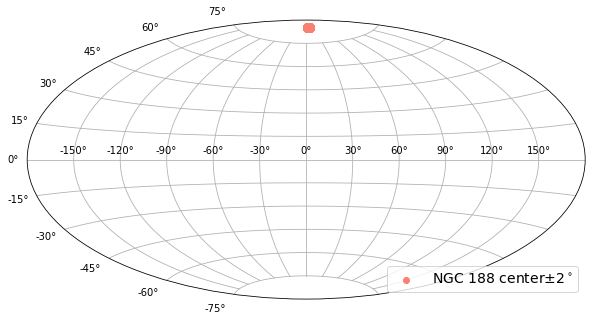

In [31]:
plt.figure(figsize=(10, 7))
plt.subplot(111, projection="aitoff")
plt.scatter(sky_coords.ra.radian, sky_coords.dec.radian, color='salmon', label=r'NGC 188 center$\pm 2^\circ$')
plt.grid()
plt.legend(loc='lower right', fontsize=14)

In [32]:
sources_clean.ra = sky_coords.ra.wrap_at(180 * u.deg).value

In [33]:
sources_clean.head()

,ra,dec,parallax,pmra,pmdec
0,-0.106868,85.175524,0.401293,1.235021,0.979092
1,-0.192938,85.196739,0.593997,2.480786,-2.629402
2,-0.020230,85.216151,0.587936,-14.802001,1.612288
3,-0.075061,85.230875,0.283472,-2.839473,-2.467185
4,-0.093472,85.234690,0.578207,-5.255996,-0.241723


In [45]:
clust = DBSCAN(eps=1.0, min_samples=20)
fit = clust.fit(sources_clean)

labels = fit.labels_
print(set(labels))

sources_clean['label'] = labels

{0, -1}


In [46]:
sources_clean.loc[sources_clean['label']==0].head()

,ra,dec,parallax,pmra,pmdec,label,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag
141,13.387256,84.403584,0.341847,-2.279798,-0.632462,0,17.985636,18.603573,17.273926
161,12.870946,84.328257,0.679504,-2.437507,-0.420658,0,17.705906,18.097715,16.930832
241,12.472166,84.449082,0.748192,-2.337831,-0.433421,0,19.473679,20.754780,18.359478
249,12.209192,84.473189,0.415085,-2.223247,-0.122604,0,19.977974,20.463396,19.258888
765,12.392731,84.556233,0.671854,-3.251933,-0.479427,0,19.226965,20.203491,18.293846


In [53]:
sources_clean = pd.concat([sources_clean, sources[['phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag']]], axis=1)

In [54]:
sources_clean = sources_clean.dropna()
sources_clean.head()

,ra,dec,parallax,pmra,pmdec,label,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag
0,-0.106868,85.175524,0.401293,1.235021,0.979092,-1,18.654993,19.398308,17.820200,18.654993,19.398308,17.820200,18.654993,19.398308,17.820200
1,-0.192938,85.196739,0.593997,2.480786,-2.629402,-1,18.336130,19.241438,17.413353,18.336130,19.241438,17.413353,18.336130,19.241438,17.413353
2,-0.020230,85.216151,0.587936,-14.802001,1.612288,-1,19.920584,20.704277,18.904068,19.920584,20.704277,18.904068,19.920584,20.704277,18.904068
3,-0.075061,85.230875,0.283472,-2.839473,-2.467185,-1,20.676477,20.720215,19.559896,20.676477,20.720215,19.559896,20.676477,20.720215,19.559896
4,-0.093472,85.234690,0.578207,-5.255996,-0.241723,-1,19.411713,20.217930,18.708126,19.411713,20.217930,18.708126,19.411713,20.217930,18.708126


In [55]:
sources_labeled = sources_clean[sources_clean['label']==0]
len(sources_labeled)

1208

In [56]:
sources_noise = sources_clean[sources_clean['label']==-1]
len(sources_noise)

12375

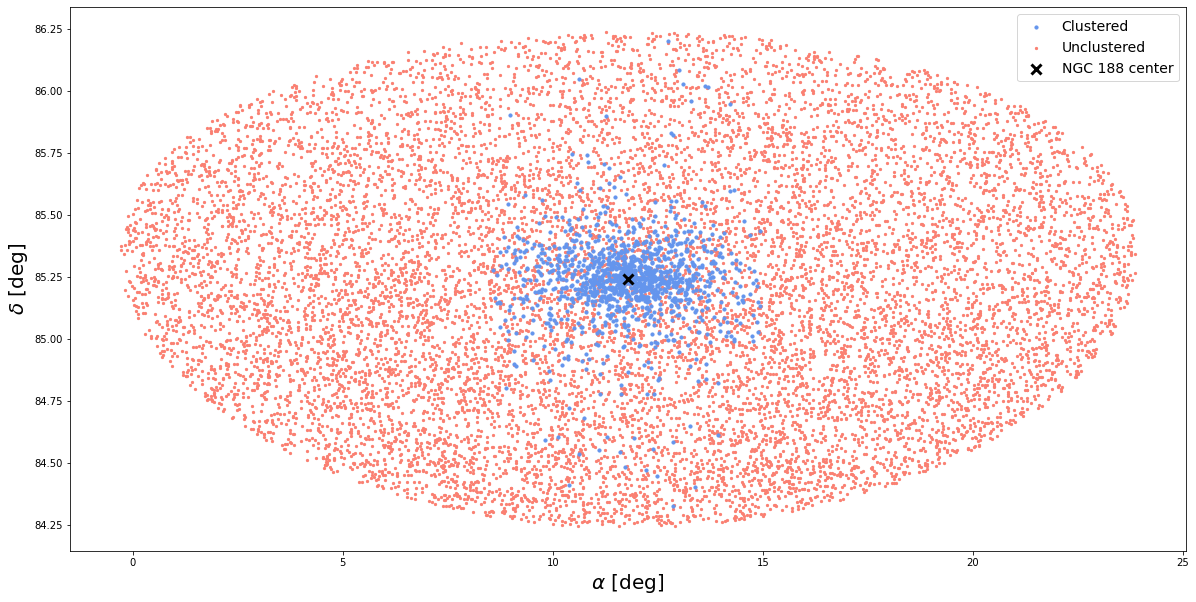

In [57]:
plt.figure(figsize=(20, 10))
plt.scatter(sources_labeled.ra, sources_labeled.dec, color='cornflowerblue', label='Clustered', zorder=2, s=10.)
plt.scatter(sources_noise.ra, sources_noise.dec, color='salmon', label='Unclustered', zorder=1, s=5.)
plt.scatter(RA, DEC, marker='x', linewidths=3., zorder=3, s=100, color='black', label='NGC 188 center');
plt.legend(fontsize=14);
plt.gca().set_xlabel('$\\alpha$ [deg]', fontsize=20);
plt.gca().set_ylabel('$\delta$ [deg]', fontsize=20);

In [58]:
plt.scatter(sources_labeled.phot_bp_mean_mag-sources_labeled.phot_rp_mean_mag, sources_labeled.phot_g_mean_mag-10+5*np.log10(sources_labeled.parallax))
plt.gca().invert_yaxis()

TypeError: '<' not supported between instances of 'str' and 'int'